# Advantage Actor-Critic


In [ ]:
!apt-get install -y xvfb

!pip install \
  gymnasium==0.26.3 \
  pygame \
  pytorch-lightning==1.6 \
  pyvirtualdisplay

#### Setup virtual display

In [ ]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

#### Import the necessary code libraries

In [18]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from torch.distributions import Normal

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, NormalizeObservation


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [19]:
device

'cuda:0'

In [47]:
@torch.no_grad()
def test_env(env_name, policy, obs_rms, **kwargs):
  env = gym.make(env_name, **kwargs, render_mode='rgb_array')
  env = RecordVideo(env, './videos1', episode_trigger=lambda e: True)
  env = NormalizeObservation(env)
  env.obs_rms = obs_rms
  policy = policy.to(device)

  for episode in range(10):
    done = False
    truncate = False
    obs, _ = env.reset()
    print(episode)
    while not (done or truncate):
      loc, scale = policy(obs)
      action = torch.normal(loc, scale)
      action = action.cpu().numpy()
      obs, _, done, truncate, _ = env.step(action)
      print(truncate or done)
  env.close()



def display_video(episode=0):
  video_file = open(f'/videos1/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the policy

In [29]:
class GradientPolicy(nn.Module):

  def __init__(self, in_features, out_dims, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc_mu = nn.Linear(hidden_size, out_dims)
    self.fc_std = nn.Linear(hidden_size, out_dims)

  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    loc = self.fc_mu(x)
    loc = torch.tanh(loc) * 2#the reason for multiplyting it with 2 is that hyperbolic will constrain the mean value between -1 and +1
    #and we know that the valid range of actions of our environment is from -2 to +2(after looking at the action_space)
    scale = self.fc_std(x)
    scale = F.softplus(scale) + 0.001
    return loc, scale

In [30]:
class ValueNet(nn.Module):

  def __init__(self, in_features, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
  
  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

#### Create the environment

In [23]:
env = gym.make("Pendulum-v1", render_mode='rgb_array')
obs=env.reset()

In [7]:
obs

(array([ 0.7334223 , -0.67977333, -0.44060284], dtype=float32), {})

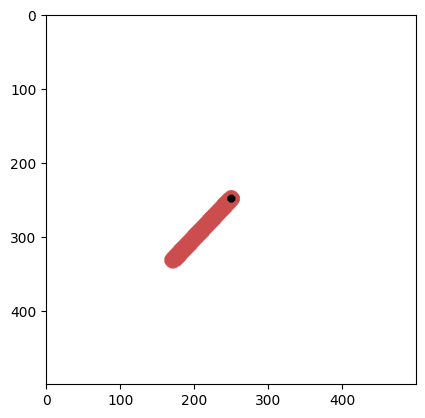

In [18]:
import matplotlib.pyplot as plt
plt.imshow(env.render())

In [22]:
env = gym.vector.make("Pendulum-v1", num_envs=2)

Exception ignored in: <function AsyncVectorEnv.__del__ at 0x7f7af7b54ee0>
Traceback (most recent call last):
  File "/home/akhters/.local/lib/python3.8/site-packages/gym/vector/async_vector_env.py", line 546, in __del__
    self.close(terminate=True)
  File "/home/akhters/.local/lib/python3.8/site-packages/gym/vector/vector_env.py", line 205, in close
    self.close_extras(**kwargs)
  File "/home/akhters/.local/lib/python3.8/site-packages/gym/vector/async_vector_env.py", line 481, in close_extras
    process.join()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 47, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [ ]:
env.reset()

(array([[ 0.96640164, -0.25703672, -0.2707829 ]], dtype=float32), {})

In [ ]:
env.observation_space, env.action_space

(Box([[-1. -1. -8.]], [[1. 1. 8.]], (1, 3), float32),
 Box(-2.0, 2.0, (1, 1), float32))

In [ ]:
next_obs, rewards, dones, truncate, infos = env.step(env.action_space.sample())

In [16]:
next_obs, rewards, dones, truncate, infos

(array([[-0.03214012, -0.99948335, -2.1202781 ],
        [ 0.20751476, -0.9782319 , -1.8866554 ]], dtype=float32),
 array([-2.35998142, -1.77925916]),
 array([False, False]),
 array([False, False]),
 {})

In [31]:
def create_env(env_name, num_envs):
  env = gym.vector.make(env_name, num_envs)
  env = RecordEpisodeStatistics(env)#wrapping this environment with the RecordEpisodeStatistics wrapper just to make sure that the environment keeps a list of the
  #episode returns obtained by our agent so that we can log it into our visualisation tool
  env = NormalizeObservation(env)
  return env

#### Create the dataset

In [32]:
class RLDataset(IterableDataset):

  def __init__(self, env, policy, steps_per_epoch):#steos_per_epoch decide how many samples we are going to collect for every epoch of traning
    self.env = env
    self.policy = policy
    self.steps_per_epoch = steps_per_epoch
    self.obs, _ = env.reset()

  @torch.no_grad()
  def __iter__(self):
    for step in range(self.steps_per_epoch):
      loc, scale = self.policy(self.obs)
      action = torch.normal(loc, scale)
      action = action.cpu().numpy()#we are making action a numpy array because those are the values that our environment works with
      next_obs, reward, done, truncate, info = self.env.step(action)
      yield (torch.tensor(self.obs, dtype=torch.float32),
                   torch.tensor(action, dtype=torch.float32),
                   torch.tensor(reward, dtype=torch.float32),
                   torch.tensor((truncate or done), dtype=torch.bool),
                   torch.tensor(next_obs, dtype=torch.float32))
      # yield self.obs, action, reward, done, next_obs#we are returning as we are generating the data
      #our dataloader will take care of batching several of these samples of experience together to form a traning step
      self.obs = next_obs

#### Create the A2C algorithm

In [33]:
class A2C(LightningModule):

  def __init__(self, env_name, num_envs=64, samples_per_epoch=8,
               batch_size=1, hidden_size=64, policy_lr=1e-4, value_lr=1e-3,
               gamma=0.99, entropy_coef=0.01, optim=AdamW):
    
    super().__init__()
    self.automatic_optimization = False  # Disable automatic optimization
    #for using more than two optimisers
    self.env = create_env(env_name, num_envs=num_envs)

    obs_size = self.env.single_observation_space.shape[0]
    action_dims = self.env.single_action_space.shape[0]

    self.policy = GradientPolicy(obs_size, action_dims, hidden_size)
    self.value_net = ValueNet(obs_size, hidden_size)
    self.target_value_net = copy.deepcopy(self.value_net)

    self.dataset = RLDataset(self.env, self.policy, samples_per_epoch)

    self.save_hyperparameters()

  def configure_optimizers(self):
    value_opt = self.hparams.optim(self.value_net.parameters(), lr=self.hparams.value_lr)
    policy_opt = self.hparams.optim(self.policy.parameters(), lr=self.hparams.policy_lr)
    return value_opt, policy_opt

  def train_dataloader(self):
    return DataLoader(dataset=self.dataset, batch_size=self.hparams.batch_size)
  
  def collate_fn(self, batch):
        return tuple(torch.stack(samples) for samples in zip(*batch))

  def training_step(self, batch, batch_idx):
    # print(f'This is batch {batch}')
    # print(f'This len of batch {len(batch)}')
    # print(f'This is data type of batch {type(batch)}')
    # # print(f'This is batch.shape {batch.shape}')
    # print(f'This is batch[0] {batch[0]}')
    # print(f'This is length of batch[0] {len(batch[0])}')
    # print(f'This is type of batch[0] {type(batch[0])}')
    # print(f'This is batch[0][0] {batch[0][0]}')
    # print(f"This is len of batch[0][0] {len(batch[0][0])}")
    # print(f'This is len(type[0][0]) {type(batch[0][0])}')
    # # print(f'This is batch[0][1] {batch[0][1]}')
    # # print(f"This is len of batch[0][1] {len(batch[0][1])}")
    # # print(f'This is len(type[0][1]) {type(batch[0][1])}')
    # print(f'This is shape of batch[0] {batch[0].shape}')
    # # print(f'This is data type of batch[0] {type(batch[0])}')
    # # print(f'This is data type of batch[0][0] {type(batch[0][0])}')
    # print(f'This is batch[0].shape[0:2] {batch[0].shape[0:2]}')
    # samples, envs = batch[0].shape[0:2]
    # print(f"This is samples {samples}")
    # print(f"This is envs {envs}")
    # print(f'This is data type of samples {type(samples)}')
    # print(f"This is data type of envs {type(envs)}")
    reshape_fn = lambda x: x.view(samples * envs, -1)
    obs_b, action_b, reward_b, done_b, next_obs_b = batch
    samples, envs = obs_b.shape[0:2]
    reshape_fn = lambda x: x.view(samples * envs, -1)
    # num_samples = self.hparams.num_envs * self.hparams.samples_per_epoch
    obs_b, action_b, reward_b, done_b, next_obs_b = map(reshape_fn, batch)
    value_opt, policy_opt = self.optimizers()
    state_values = self.value_net(obs_b)

    with torch.no_grad():
      next_state_values = self.target_value_net(next_obs_b)
      # print(done_b)
      next_state_values[done_b] = 0.0
      target = reward_b + self.hparams.gamma * next_state_values
    
    # if optimizer_idx == 0:
    value_loss = F.smooth_l1_loss(state_values, target)
    self.log("episode/Value Loss", value_loss)
    value_opt.zero_grad()
    value_loss.backward()
    value_opt.step()
    # return loss
    
    # elif optimizer_idx == 1:
    advantages = (target - state_values).detach()#we don't wish to take gradient of the target

    loc, scale = self.policy(obs_b)
    dist = Normal(loc, scale)

    log_probs = dist.log_prob(action_b).sum(dim=-1, keepdim=True)
    entropy = dist.entropy().sum(dim=-1, keepdim=True)

    pg_loss = - log_probs * advantages
    policy_loss = (pg_loss - self.hparams.entropy_coef * entropy).mean()#why taking mean here?
# The .mean() operation is applied to true_policy_loss before calling .backward() because true_policy_loss is typically a tensor with more than one element. PyTorch requires that gradients be computed on scalar values (tensors with a single element), not on multi-element tensors. 
# Here's a more detailed explanation:
# Understanding the Need for .mean()
# Multi-element Tensors:
# The true_policy_loss is computed for each element in the batch, resulting in a tensor of losses. This tensor will have one loss value per sample in the batch.
# Backpropagating through a multi-element tensor without reducing it to a scalar can lead to ambiguity, as it is not clear how to aggregate the gradients across the different elements.
# Gradient Calculation:
# In order to perform backpropagation, PyTorch needs a scalar loss value. Taking the mean (or sum) of the true_policy_loss tensor reduces it to a single scalar value.
# This scalar loss value is then used to compute gradients via the .backward() method, ensuring that the gradients are correctly aggregated across the batch.
# Gradient Consistency:
# Taking the mean of the losses before backpropagation ensures consistent gradient magnitudes, regardless of batch size. This helps maintain stable learning rates and training dynamics.
# Example Code
# In your training_step method, the true_policy_loss tensor is created by combining the policy loss and entropy penalty for each sample in the batch. To perform backpropagation correctly, you take the mean of this tensor before calling .backward():
    policy_opt.zero_grad()
    policy_loss.backward()
    policy_opt.step()
    
    self.log("episode/PG Loss", pg_loss.mean())
    self.log("episode/Entropy", entropy.mean())

    # return loss
    
  def on_train_epoch_end(self):
    if self.current_epoch > 0 and self.current_epoch % 25 == 0:
      self.log("episode/Return", self.env.return_queue[-1])
    
    if self.current_epoch > 0 and self.current_epoch % 10 == 0:
      #updating the target network
      self.target_value_net.load_state_dict(self.value_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [27]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

rm: cannot remove '/content/lightning_logs/': No such file or directory
rm: cannot remove '/content/videos/': No such file or directory


ERROR: Failed to start `tensorboard`: [Errno 8] Exec format error:
'tensorboard'

#### Train the policy

In [34]:
algo = A2C("Pendulum-v1")

trainer = Trainer(
    # gpus=num_gpus,
    max_epochs=2000,
    log_every_n_steps=1
)

trainer.fit(algo)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | policy           | GradientPolicy | 4.5 K  | train
1 | value_net        | ValueNet       | 4.5 K  | train
2 | target_value_net | ValueNet       | 4.5 K  | train
------------------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_129030/3151247593.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_129030/2397782955.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().to(device)
/tmp/ipykernel_129030/2530479910.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().to(device)
`Trainer.fit` stopped: `max_epochs=2000` reached.


#### Check the resulting policy

In [48]:
import warnings
warnings.filterwarnings('ignore')

test_env('Pendulum-v1', algo.policy, algo.env.obs_rms)

0
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-0.mp4
True
1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-1.mp4
True
2
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-2.mp4
True
3
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-3.mp4
True
4
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-4.mp4
True
5
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-5.mp4
True
6
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-6.mp4
True
7
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-7.mp4
True
8
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-8.mp4
True
9
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_pg_methods_complete/videos1/rl-video-episode-9.mp4
True


In [49]:
display_video(episode=5)

FileNotFoundError: [Errno 2] No such file or directory: '/videos1/rl-video-episode-5.mp4'